This notebook uses a current PR of gcr-catalogs, make sure you clone the PR and add it to `sys.path`
```
git clone -b coadd_reader git@github.com:djperrefort/gcr-catalogs.git
```

This notebook also requires `FoFCatalogMatching`: https://github.com/yymao/FoFCatalogMatching

In [3]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
sys.path.insert(0, '/global/homes/b/bhairav/gcr-catalogs')
from collections import defaultdict
import numpy as np
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs
from scipy.optimize import curve_fit

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')
coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [6]:
#for data in coaddCat.get_quantities(['ra', 'dec'], return_iterator=True):
#    plt.scatter(data['ra'], data['dec'], s=1, rasterized=True);

#plt.xlabel('RA');
#plt.ylabel('Dec');

In [7]:
# do matching on a small area
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filter = GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
)

In [8]:
mag_cutIn = GCRQuery(
    (np.isfinite, 'lsst_u'),
    'lsst_u < 45',
#    (np.isfinite, 'i_magLSST'),
#    'i_magLSST < 24.5',
)
mag_cutOut = GCRQuery(
    (np.isfinite, 'mag_i_lsst'),
    'mag_i_lsst < 24.5'
)

In [9]:
coordinatesCoaddCat = coaddCat.get_quantities(['ra', 'dec'], filters=[coord_filter])

#filters=[coord_filter, mag_cut])

In [10]:
refCat = GCRCatalogs.load_catalog('dc2_reference_run1.1p')
#refCat.add_quantity_modifier('i_magLSST', 'lsst_i')

In [11]:
coordinatesRefCat = refCat.get_quantities(['ra', 'dec'], filters=[coord_filter])
#filters=[coord_filter, mag_cut])

/global/homes/b/bhairav/gcr-catalogs/GCRCatalogs/reference_catalog.py:59: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [13]:
results = FoFCatalogMatching.match(
    catalog_dict=dict(ref=coordinatesRefCat, coadd=coordinatesCoaddCat),
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [14]:
n_max = 5
hist2d = np.zeros((n_max, n_max))
ref_idx = defaultdict(list)
coadd_idx = defaultdict(list)

for group in results.groups:
    ref_mask = group['catalog_key'] == 'ref'
    coadd_mask = group['catalog_key'] == 'coadd'
    
    n_ref = np.count_nonzero(ref_mask)
    n_coadd = np.count_nonzero(coadd_mask)
    if n_ref < n_max and n_coadd < n_max:
        hist2d[n_ref, n_coadd] += 1
    
    key = (n_ref, n_coadd)
    ref_idx[key].append(group['row_index'][ref_mask].data)
    coadd_idx[key].append(group['row_index'][coadd_mask].data)

for key in ref_idx:
    ref_idx[key] = np.concatenate(ref_idx[key])
    coadd_idx[key] = np.concatenate(coadd_idx[key])

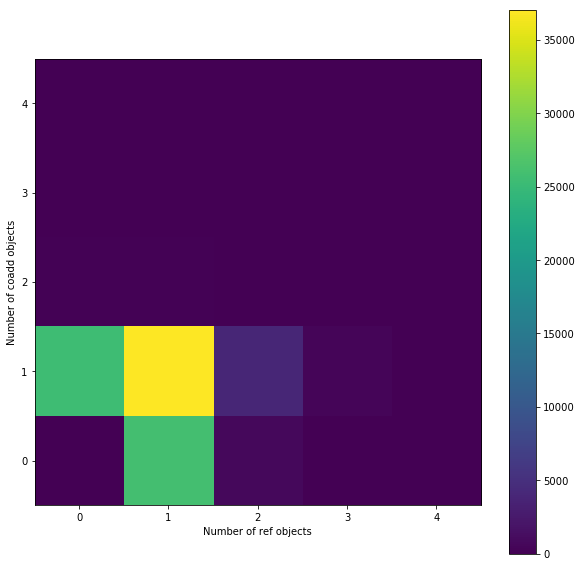

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(hist2d.T, extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of ref objects');
plt.ylabel('Number of coadd objects');
plt.colorbar();

In [13]:
delta_ra = coordinatesCoaddCat['ra'][coadd_idx[(1,1)]] - coordinatesRefCat['ra'][ref_idx[(1,1)]]
delta_dec = coordinatesCoaddCat['dec'][coadd_idx[(1,1)]] - coordinatesRefCat['dec'][ref_idx[(1,1)]]

ref_sc = SkyCoord(coordinatesRefCat['ra'][ref_idx[(1,1)]], coordinatesRefCat['dec'][ref_idx[(1,1)]], unit="deg")
coadd_sc = SkyCoord(coordinatesCoaddCat['ra'][coadd_idx[(1,1)]], coordinatesCoaddCat['dec'][coadd_idx[(1,1)]], unit="deg")
delta_arcsec = ref_sc.separation(coadd_sc).arcsec

/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


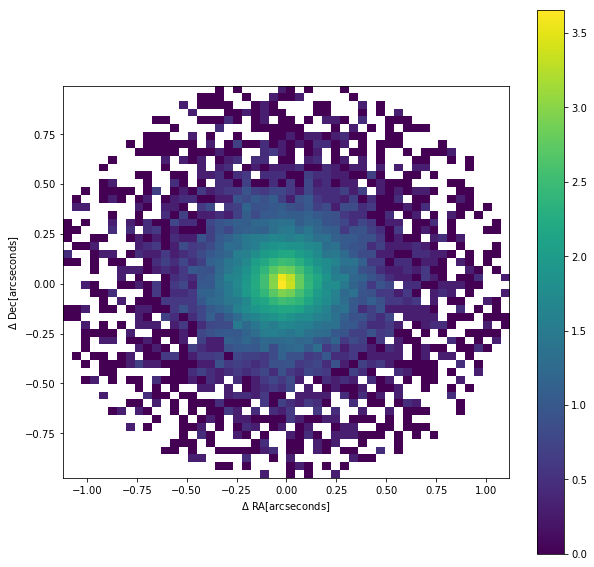

In [14]:
hist, xedges, yedges = np.histogram2d(delta_ra, delta_dec, bins=50)
plt.figure(figsize=(10, 10))
extent = (xedges[0]*3600, xedges[-1]*3600, yedges[0]*3600, yedges[-1]*3600)
plt.imshow(np.log10(hist), extent=extent)

#plt.hist2d(delta_ra, delta_dec, bins=40);
plt.xlabel(r'$\Delta$ RA[arcseconds]')
plt.ylabel(r'$\Delta$ Dec[arcseconds]')
plt.colorbar()

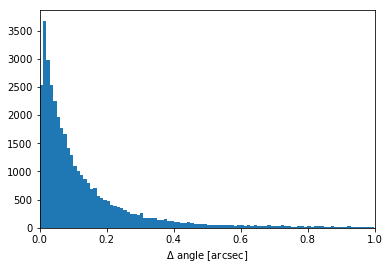

In [15]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=100);
plt.xlim(0, 1.0);
plt.xlabel(r'$\Delta$ angle [arcsec]');

In [16]:
decIn = coordinatesRefCat['dec'][ref_idx[(1,1)]]
decOut = coordinatesCoaddCat['dec'][coadd_idx[(1,1)]]
decIn *= np.pi/180
decOut *= np.pi/180
delta_ra *= np.pi/180
delta_dec *= np.pi/180
meanDec = 0.5 * (decIn + decOut)
deltaDMean = np.sqrt(np.square(delta_ra * np.cos(meanDec)) + np.square(delta_dec))
deltaDMean *= 180*3600/np.pi

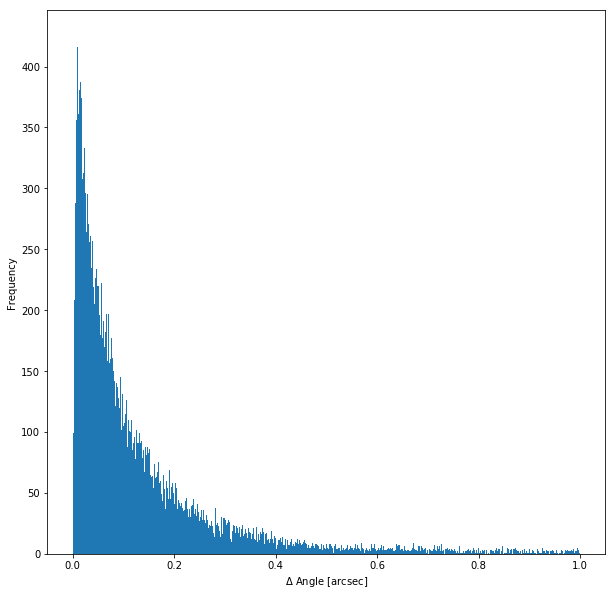

In [17]:
plt.figure(figsize=(10, 10))
plt.xlabel('$\Delta$ Angle [arcsec]')
plt.ylabel('Frequency')
values, edges, _ = plt.hist(deltaDMean, bins=1000)

162014.200391
14.9043826759


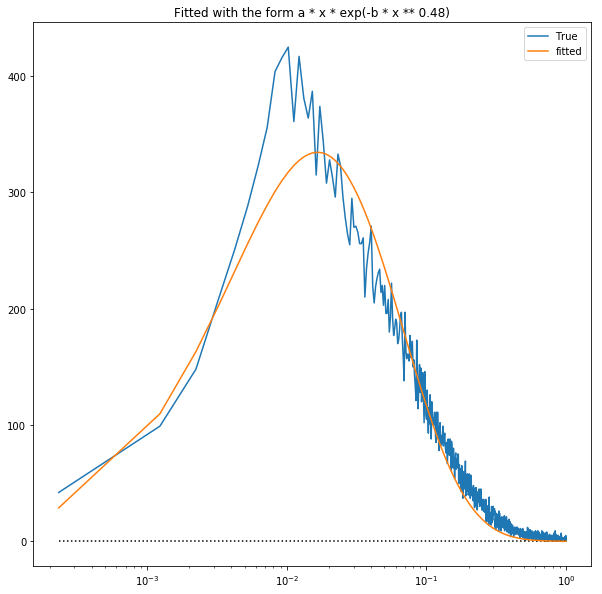

In [113]:
plt.figure(figsize = (10, 10))
plt.plot(edges[:-1], values, label='True')
plt.semilogx()
x_data = edges[:-1]
y_data = values
plt.plot(edges[:-1], values*0., 'k:')
def fitfunction1(x, a, b):
    y = a * x * np.exp(-b * x ** 0.48)
    return y
(A, B), _ = curve_fit(fitfunction1, x_data, y_data)
print(A)
print(B)
plt.plot(x_data, fitfunction1(x_data, A, B), label='fitted')
plt.title('Fitted with the form a * x * exp(-b * x ** 0.48)')
plt.legend(loc='upper right')

In [20]:
magInputs = refCat.get_quantities(['lsst_u',
                                   'lsst_g', 
                                   'lsst_r',
                                   'lsst_i',
                                   'lsst_z',
                                   'lsst_y'], filters=[coord_filter])

/global/homes/b/bhairav/gcr-catalogs/GCRCatalogs/reference_catalog.py:59: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [50]:
coaddCat.list_all_quantities()
magOutputs = coaddCat.get_quantities(['mag_u_lsst',
                                   'mag_g_lsst', 
                                   'mag_r_lsst',
                                   'mag_i_lsst',
                                   'mag_z_lsst',
                                   'mag_y_lsst'], filters=[coord_filter])

In [51]:
inputU = magInputs['lsst_u']
inputG = magInputs['lsst_g']
inputR = magInputs['lsst_r']
inputI = magInputs['lsst_i']
inputZ = magInputs['lsst_z']
inputY = magInputs['lsst_y']

outputU = magOutputs['mag_u_lsst']
outputG = magOutputs['mag_g_lsst']
outputR = magOutputs['mag_r_lsst']
outputI = magOutputs['mag_i_lsst']
outputZ = magOutputs['mag_z_lsst']
outputY = magOutputs['mag_y_lsst']

In [52]:
inputU11 = (inputU[ref_idx[(1,1)]])
inputG11 = (inputG[ref_idx[(1,1)]])
inputR11 = (inputR[ref_idx[(1,1)]])
inputI11 = (inputI[ref_idx[(1,1)]])
inputZ11 = (inputZ[ref_idx[(1,1)]])
inputY11 = (inputY[ref_idx[(1,1)]])

outputU11 = (outputU[coadd_idx[(1,1)]])
outputG11 = (outputG[coadd_idx[(1,1)]])
outputR11 = (outputR[coadd_idx[(1,1)]])
outputI11 = (outputI[coadd_idx[(1,1)]])
outputZ11 = (outputZ[coadd_idx[(1,1)]])
outputY11 = (outputY[coadd_idx[(1,1)]])

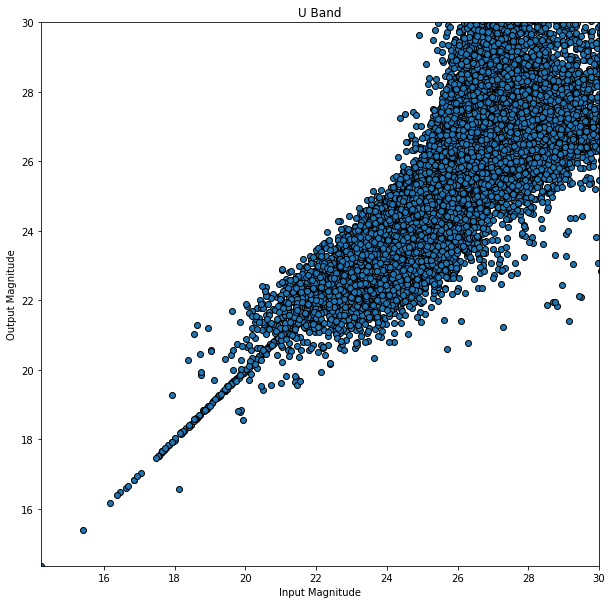

In [53]:
plt.figure(figsize=(10, 10))
plt.scatter(inputU11, outputU11, edgecolors='black')
xmin = min(inputU11)
xmax = 30
ymin = min(outputU11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("U Band")
plt.show()

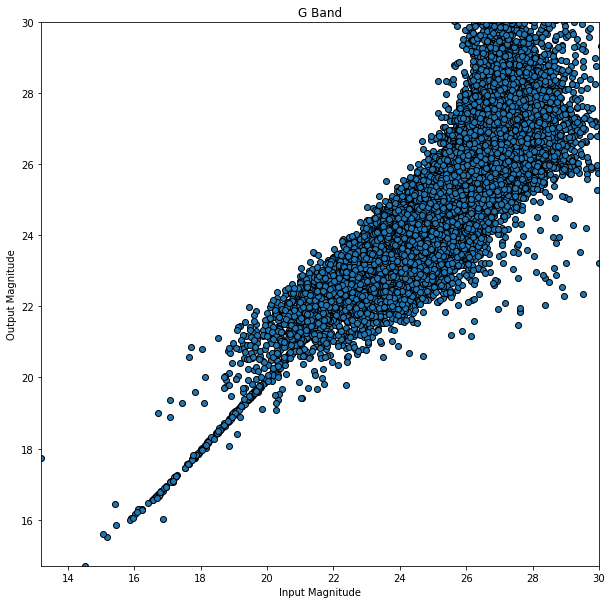

In [54]:
plt.figure(figsize=(10, 10))
plt.scatter(inputG11, outputG11, edgecolors='black')
xmin = min(inputG11)
xmax = 30
ymin = min(outputG11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("G Band")
plt.show()

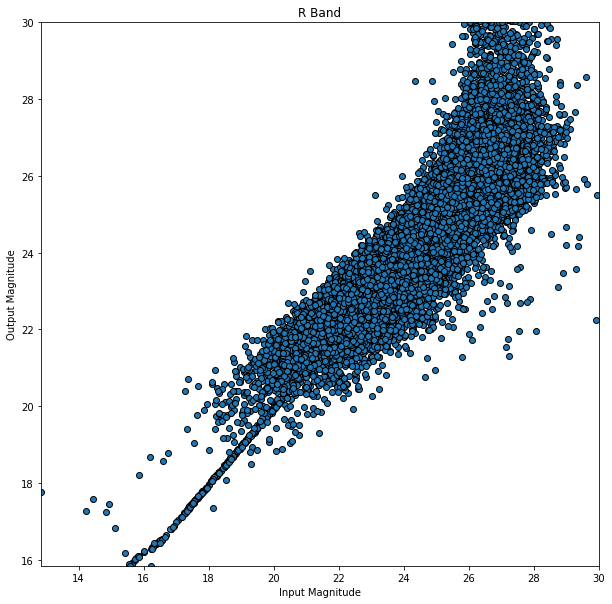

In [55]:
plt.figure(figsize=(10, 10))
plt.scatter(inputR11, outputR11, edgecolors='black')
xmin = min(inputR11)
xmax = 30
ymin = min(outputR11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("R Band")
plt.show()

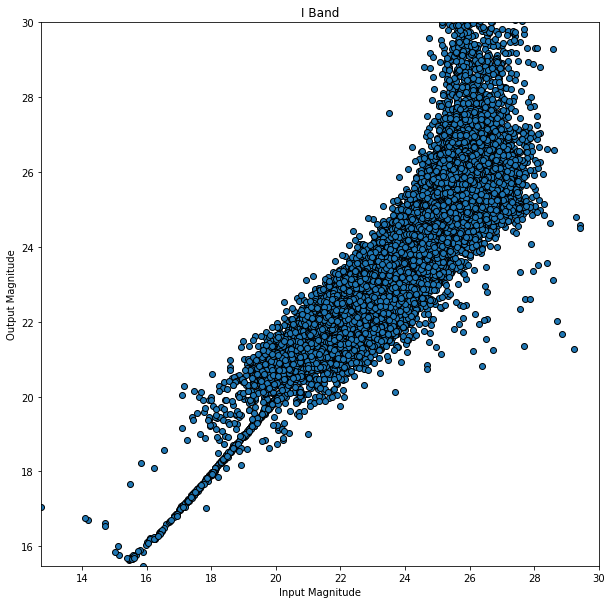

In [56]:
plt.figure(figsize=(10, 10))
plt.scatter(inputI11, outputI11, edgecolors='black')
xmin = min(inputI11)
xmax = 30
ymin = min(outputI11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("I Band")
plt.show()

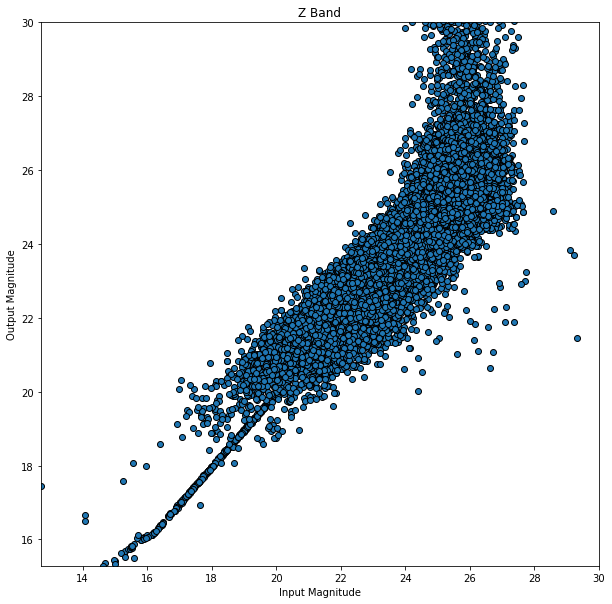

In [57]:
plt.figure(figsize=(10, 10))
plt.scatter(inputZ11, outputZ11, edgecolors='black')
xmin = min(inputZ11)
xmax = 30
ymin = min(outputZ11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("Z Band")
plt.show()

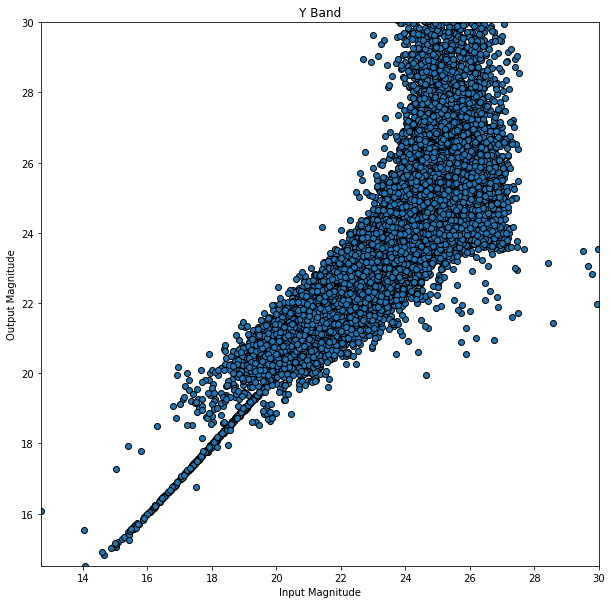

In [58]:
plt.figure(figsize=(10, 10))
plt.scatter(inputY11, outputY11, edgecolors='black')
xmin = min(inputY11)
xmax = 30
ymin = min(outputY11)
ymax = 30
axes = plt.gca()
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
plt.xlabel("Input Magnitude")
plt.ylabel("Output Magnitude")
plt.title("Y Band")
plt.show()

In [72]:
outputU01 = (outputU[coadd_idx[(0,1)]])
outputU01 = outputU01[~np.isnan(outputU01)]

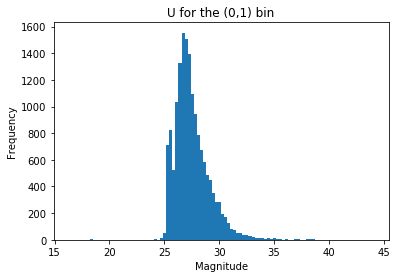

In [78]:
plt.hist(outputU01, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("U for the (0,1) bin")

In [121]:
outputU11 = (outputU[coadd_idx[(1,1)]])
print(outputU11)
outputU11 = outputU11[~np.isnan(outputU11)]

[ 29.85934783  27.9020271   21.47349065 ...,  23.97205601  24.66396577
  23.34127465]


[ 29.85934783  27.9020271   21.47349065 ...,  23.97205601  24.66396577
  23.34127465]


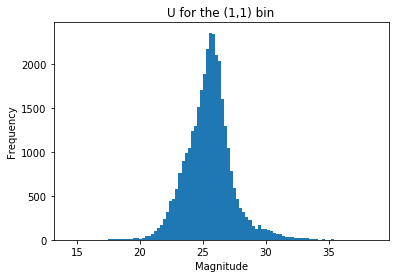

In [124]:
plt.hist(outputU11, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("U for the (1,1) bin")
print(outputU11)

In [96]:
outputG01 = (outputG[coadd_idx[(0,1)]])
outputG01 = outputG01[~np.isnan(outputG01)]

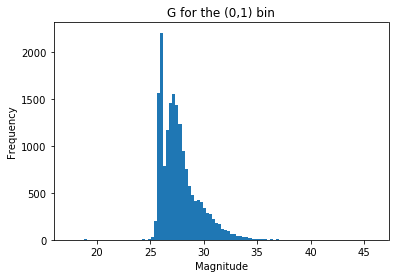

In [99]:
plt.hist(outputG01, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("G for the (0,1) bin")

In [110]:
outputG10 = (outputG[coadd_idx[(1,0)]])
outputG10 = outputG10[~np.isnan(outputG10)]

In [119]:
type(outputG10)
len(coadd_idx[(1,0)])

0

[]


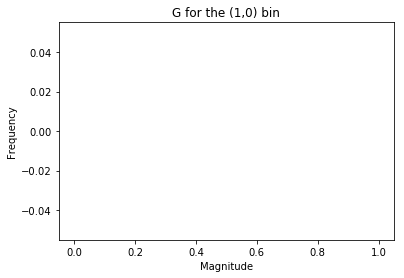

In [111]:
plt.hist(outputG10, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("G for the (1,0) bin")
print(outputG10)

In [1]:
coordinatesCoaddCat.add_quantity_modifier('i_mag_cmodel', 
                              (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), 
                              overwrite=True)
coordinatesCoaddCat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), 
                              overwrite=True)
coordinatesCoaddCat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
coordinatesCoaddCat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
coordinatesCoaddCat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'i_base_SdssShape_psf_xx', 'i_base_SdssShape_psf_yy', 'i_base_SdssShape_psf_xy'),
                              overwrite=True)

NameError: name 'coordinatesCoaddCat' is not defined

In [2]:
lensing_cuts = [
    ~GCRQuery((np.isnan, 'i_modelfit_CModel_flux')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('i_mag_cmodel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('base_Blendedness_abs_flux < 10**(-0.375)'),
]

NameError: name 'GCRQuery' is not defined